In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/weds_vids.zip -d /content/videos


Archive:  /content/drive/MyDrive/weds_vids.zip
   creating: /content/videos/content/preprocessed_videos/
  inflating: /content/videos/content/preprocessed_videos/8044819-hd_1080_1920_25fps.mp4  
  inflating: /content/videos/content/preprocessed_videos/5195355-uhd_3840_2160_30fps.mp4  
  inflating: /content/videos/content/preprocessed_videos/8865622-uhd_2160_4096_25fps.mp4  
  inflating: /content/videos/content/preprocessed_videos/The Future of Business_ Young Woman Walking on a Green Screen Chroma.mp4  
  inflating: /content/videos/content/preprocessed_videos/7218892-uhd_2160_3840_24fps.mp4  
  inflating: /content/videos/content/preprocessed_videos/5265106-uhd_4096_2160_25fps.mp4  
  inflating: /content/videos/content/preprocessed_videos/4625326-hd_1080_1920_25fps.mp4  
  inflating: /content/videos/content/preprocessed_videos/7539030-uhd_2160_3840_24fps.mp4  
  inflating: /content/videos/content/preprocessed_videos/5989759-uhd_2160_3840_25fps.mp4  
  inflating: /content/videos/content/

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 349, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 349 (delta 29), reused 16 (delta 16), pack-reused 290
Receiving objects: 100% (349/349), 42.95 MiB | 11.67 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 18.5 kB/s eta 0:00:00
  Building edit

In [6]:
!pip install -q supervision[assets] jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 11.6 MB/s eta 0:00:00


In [7]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [8]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [9]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model

In [10]:
cd /content/segment-anything-2

/content/segment-anything-2


In [11]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(CONFIG, CHECKPOINT)

## Preprocess video

### Download video and split it into frames

**NOTE:** SAM2 assumee that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`. Let's start by downloading a sample video, splitting it into frames, and saving them to disk. Feel free to replace `SOURCE_VIDEO` with the path to your video file.

In [464]:
vid_name = 'm.mp4'
SOURCE_VIDEO = f'/content/preprocessed_videos/{vid_name}'
sv.VideoInfo.from_video_path(SOURCE_VIDEO)

VideoInfo(width=1920, height=1080, fps=60, total_frames=761)

In [13]:
import cv2

def count_frames(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return 0

    # Initialize frame count
    frame_count = 0

    # Count the frames
    while True:
        # Read the next frame from the video
        ret, frame = cap.read()

        # If frame is read correctly, ret is True
        if not ret:
            break

        # Increment the frame count
        frame_count += 1

    # Release the video capture object
    cap.release()

    return frame_count

# Usage
video_file = SOURCE_VIDEO
total_frames = count_frames(video_file)

In [14]:
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [465]:
total_frames = count_frames(SOURCE_VIDEO)
SCALE_FACTOR = 1
START_IDX = 0
END_IDX = total_frames

In [473]:
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=START_IDX, end=END_IDX)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

In [17]:
import matplotlib.pyplot as plt

In [438]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [19]:
from PIL import Image

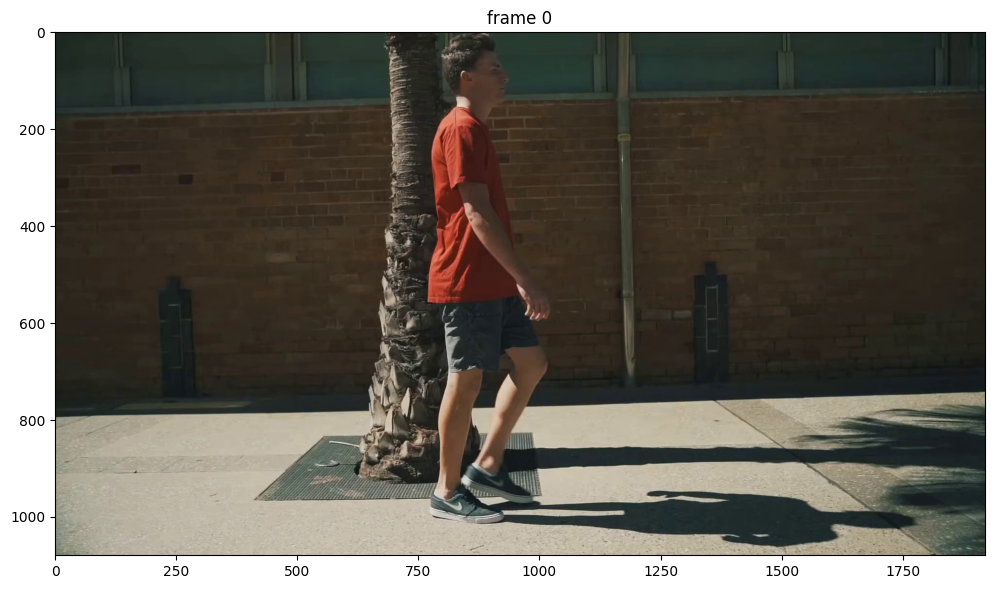

In [474]:

video_dir = f"/content/{vid_name.split('.')[0]}"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [476]:
inference_state = predictor.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 155/155 [00:08<00:00, 19.27it/s]


In [475]:
predictor.reset_state(inference_state)

In [427]:
import shutil
shutil.rmtree('/content/segmented_frames')

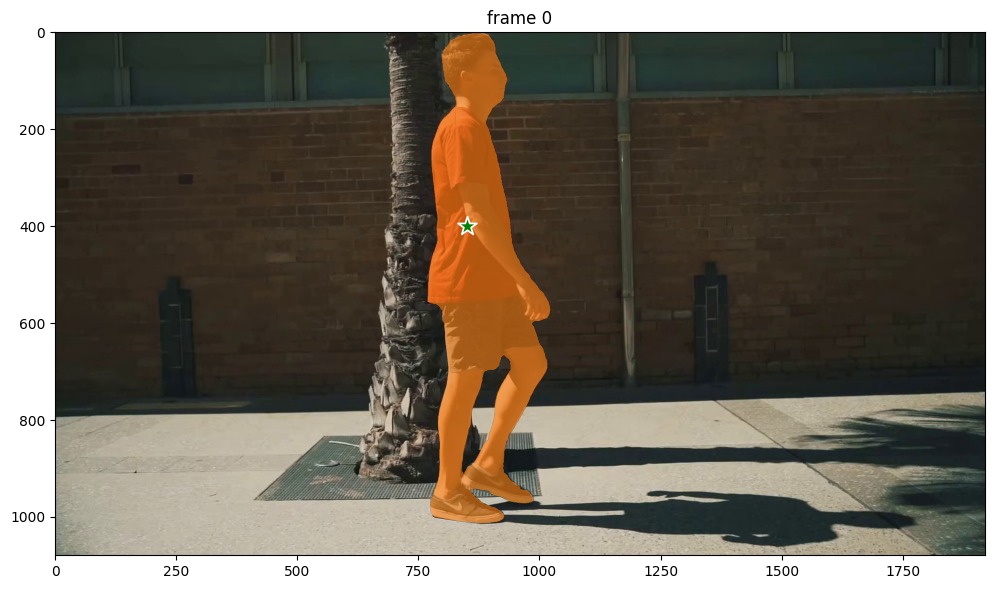

In [477]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

points = np.array([[850,400]], dtype=np.float32)
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [478]:
import os
output_dir = '/content/segmented_frames'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist


from PIL import Image

# Run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


propagate in video: 100%|██████████| 155/155 [00:07<00:00, 21.65it/s]


In [479]:
import cv2
import numpy as np
import os

for out_frame_idx in video_segments.keys():
    # Load the original frame
    frame_path = os.path.join(video_dir, frame_names[out_frame_idx])
    frame = cv2.imread(frame_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    full_mask = np.zeros(frame.shape[:2], dtype=bool)

    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        out_mask_bool = np.squeeze(out_mask.astype(bool))
        if out_mask_bool.shape == full_mask.shape:
            full_mask |= out_mask_bool
        else:
            print(f"Shape mismatch detected after squeezing: {out_mask_bool.shape} vs {full_mask.shape}")
    masked_frame = np.zeros_like(frame)
    masked_frame[full_mask] = frame[full_mask]
    masked_frame = cv2.cvtColor(masked_frame, cv2.COLOR_RGB2BGR)
    output_frame_path = os.path.join(output_dir, f'{out_frame_idx:05d}.jpg')
    cv2.imwrite(output_frame_path, masked_frame)



In [480]:
output_video_path = f"/content/output_videos/{vid_name.split('.')[0]}.mp4"
!ffmpeg -framerate 30 -i '{output_dir}/%05d.jpg' -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p '{output_video_path}'


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [446]:
import shutil
shutil.rmtree('/content/segmented_frames')
import os
shutil.rmtree(video_dir)
os.remove(SOURCE_VIDEO)